# Data Setup

In [1]:
import kagglehub
import os
import numpy as np
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("fmena14/volcanoesvenus")

# Get the list of all files and directories 
files = os.listdir(path)
print(f"Files and directories in '{path}':\n{files}")  

train_files = os.listdir(os.path.join(path, 'Volcanoes_train'))
test_files = os.listdir(os.path.join(path, 'Volcanoes_test'))

# Check files inside the 'Volcanoes_test' and 'Volcanoes_train' files
print(f"Files in 'Volcanoes_train':\n{train_files}")
print(f"Files in 'Volcanoes_test':\n{test_files}")

# We use 'header=None' for 'X_train' and 'X_test' so pandas doesn't treat the first row as indeces
X_train = pd.read_csv(os.path.join(path, 'Volcanoes_train', 'train_images.csv'), header=None)
y_train = pd.read_csv(os.path.join(path, 'Volcanoes_train', 'train_labels.csv'))
X_test = pd.read_csv(os.path.join(path, 'Volcanoes_test', 'test_images.csv'), header=None)
y_test = pd.read_csv(os.path.join(path, 'Volcanoes_test', 'test_labels.csv'))

Files and directories in 'C:\Users\lotop\.cache\kagglehub\datasets\fmena14\volcanoesvenus\versions\1':
['Volcanoes_test', 'Volcanoes_train']
Files in 'Volcanoes_train':
['train_images.csv', 'train_labels.csv']
Files in 'Volcanoes_test':
['test_images.csv', 'test_labels.csv']


# Data Preprocessing

In [2]:
print(X_train.head())
print('-'*80)
print(y_train.head())
print('-'*80)
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')
print('-'*80)
print(X_train.info())
print('-'*80)
print(y_train.info())

   0      1      2      3      4      5      6      7      8      9      ...  \
0     95    101     99    103     95     86     96     89     70    104  ...   
1     91     92     91     89     92     93     96    101    107    104  ...   
2     87     70     72     74     84     78     93    104    106    106  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4    114    118    124    119     95    118    105    116    123    112  ...   

   12090  12091  12092  12093  12094  12095  12096  12097  12098  12099  
0    111    107     92     89    103     99    117    116    118     96  
1    103     92     93     95     98    105    104    100     90     81  
2     84     71     95    102     94     80     91     80     84     90  
3     94     81     89     84     80     90     92     80     88     96  
4    116    113    102     93    109    104    106    117    111    115  

[5 rows x 12100 columns]
-------------------------------------------------

In this analysis, we are only interested in identifying the presence or absence of volcanoes. Therefore, the `Volcano?` column will be used as the target variable. Fortunately, it doesn't contain any NaN values. The NaN values in the other columns (`Type`, `Radius`, `Number Volcanoes`) are irrelevant for this task and can be safely ignored.

In [3]:
# Extract the 'Volcano?' column as the target variable
y_train = y_train['Volcano?']
y_test = y_test['Volcano?']

## Corrupted images

Before any step in our data preprocessing pipeline (normalization, dimensionality reduction, etc.) we need to address the corrupted data present in the dataset.

In [ ]:
def corruptedImages(data):
    corruptedImagesIndex = []
    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0
        for pixelIndex in range(0,len(image)):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0:
            corruptedImagesIndex.append(index)
        else:
            sum = 0

    for index, image in enumerate(np.resize(data, (data.shape[0], 12100))): # resize (7000, 110, 110, 1) to (7000,12100)
        sum = 0
        for pixelIndex in range(0,len(image),110):
            sum += image[pixelIndex]
            if pixelIndex == 10:
                break
        if sum == 0 and index not in corruptedImagesIndex:
            corruptedImagesIndex.append(index)
        else:
            sum = 0
    return corruptedImagesIndex
 
print(str(len(corruptedImages(X_train)))+" corrupted images")

209 corrupted images


In [5]:
def deleteCorrupted(X, y, corruptedIndexList):
    for i in corruptedIndexList:
        X.drop(i, inplace=True) # Drop the corrupted
        y.drop(i, inplace=True) 
    
    X.reset_index(inplace=True) # Reconstruct the index
    X.drop(['index'], axis=1, inplace=True) # Delete old index column
    #Because they are pandas.series we don't need to deal with index
    #Because we use inplace=True we don't need to return something

In [6]:
trainCorruptedList = corruptedImages(X_train)
testCorruptedList = corruptedImages(X_test)

deleteCorrupted(X_train, y_train, trainCorruptedList)
deleteCorrupted(X_test, y_test, testCorruptedList)

In [7]:
print("X_train:\t",X_train.shape,"\ny_train:\t",y_train.shape,"\nX_test:\t\t",X_test.shape,"\ny_test:\t\t",y_test.shape)

X_train:	 (6791, 12100) 
y_train:	 (6791,) 
X_test:		 (2655, 12100) 
y_test:		 (2655,)


## Data normalization

The main classifier we want to implement in this analysis is logistic regression. For this reason, the normalization of the data is required.

In this particular case, dividing all input values by the highest value ($=255$) is essentially equivalent to using the MinMaxScaler. However, the former approach has the main advantage of computational efficiency, so it's preferred.

In [8]:
def raw_image_normalizer(X):
    '''
    Takes as input flattened raw images and normalizes them by dividing its values for the highest value.

    Input parameters:
    - X: A feature matrix X.

    Output:
    - X_normalized: The respective normalized feature matrix X.
    '''

    max_value = X.values.max()
    X_normalized = X / max_value

    return X_normalized

In [9]:
# Normalization of both train and test inputs

X_train = raw_image_normalizer(X_train)
X_test = raw_image_normalizer(X_test)

## Dimensionality reduction

After normalizing the data, we can proceed to the dimensionality reduction part. 

### Why use dimensionality reduction?

In the training data, we have a total number of features ($p$) equal to $12 \, 100$, and a total number of samples ($n$) equal to $5 \, 000$. This property of our feature matrix ($p >> n$) can cause several problems, such as 

- **Overfitting**: High feature-to-sample ratios increase the risk of overfitting, leading to overly complex decision boundaries.
- **Slow computation**: High-dimensional and redundant features can make optimization methods require more iterations.

For all of the above reasons, we will use PCA to reduce the dimensionality of the data. We aim to retain about $95/%$ of the total variance.

### Why do we focus on the retained variance rather than the number of dimensions?

Rather than arbitrarily choosing the number of dimensions to reduce to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., $95\%$). Unless, of course, we are reducing the dimensionality for data visualization - in which case we will generally want to reduce the dimensionality to $2$ or $3$.

### References

- ML Jupyter book: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter8.html.
- Trevor Hastie, Robert Tibshirani, and Jerome Friedman. *The Elements of Statistical Learning* (mainly for the part regarding $p >> n$ and numerical instability).

In [10]:
from sklearn.decomposition import PCA

# Fit PCA on the training data (calculate principal components)
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

# Transform the test data using the same PCA model
X_test_reduced = pca.transform(X_test)

In [11]:
print(f"Number of components retained: {pca.n_components_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}")

Number of components retained: 2069
Cumulative explained variance: [0.55087531 0.57351014 0.58925815 ... 0.94994306 0.94998573 0.95002836]


The dimensionality was successfully reduced from $12 \, 100$ to $2 \, 069$, while retaining $95\%$ of the variance. We managed to achieve our objective in terms of dimensionality reduction.

## Oversampling

Finally, we need to address the fact that the number of volcanoes' images in the training data is just a small portion of the total number of images. For this reason, we will implement **SMOTE** (Synthetic Minority Over-sampling Technique). This algorithm allows us to generates synthetic samples by interpolating between existing minority class samples.

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train)

In [13]:
from collections import Counter

# We verify the new class distribution
print(Counter(y_train_balanced))

Counter({1: 5804, 0: 5804})


We used to have 5804 non-volcano images and 987 volcano images. After applying SMOTE, the dataset results balanced for both classes.

# Logistic regression

## Logistic regression class

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


class LogisticRegressionSGD:
    """
    Logistic Regression classifier using Stochastic Gradient Descent (SGD) optimization.

    This class supports logistic regression with various features such as:
    - Mini-batch SGD with momentum.
    - L2 regularization.
    - Early stopping with patience.
    - Hyperparameter analysis for tuning learning rate and regularization parameters.
    """
    def __init__(self, learning_rate=0.01, num_iterations=1000, batch_size=32, momentum=0.0, l2_lambda=0.0, patience=10, tol=1e-4, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.momentum = momentum
        self.l2_lambda = l2_lambda
        self.patience = patience  # Early stopping patience
        self.tol = tol  # Minimum improvement threshold for early stopping
        self.beta = None  # Vector of weights for the logistic regression model
        self.verbose = verbose
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):
        y_pred = self.sigmoid(X @ self.beta)
        # Clip y_pred to avoid log(0) issues
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        if self.l2_lambda > 0:
            loss += (self.l2_lambda / 2) * np.sum(self.beta ** 2)
        return loss

    def SGDfit(self, X, y):
        samples, features = X.shape
        self.beta = np.random.randn(features, 1) * 0.01  # Small initialization
        velocity = np.zeros((features, 1))

        # Initialize best_loss to infinity to ensure any first epoch loss will be smaller, allowing it to update.
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.num_iterations):
            # Shuffle data
            shuffled_indices = np.random.permutation(samples)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices].reshape(-1, 1)

            # Loop over mini-batches
            for i in range(0, samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                # Compute predictions
                y_predicted = self.sigmoid(X_batch @ self.beta)

                # Compute the gradient with L2 regularization
                gradient = (X_batch.T @ (y_predicted - y_batch)) / self.batch_size
                if self.l2_lambda > 0:
                    gradient += self.l2_lambda * self.beta

                # Update velocity and beta with momentum
                velocity = self.momentum * velocity + self.learning_rate * gradient
                self.beta -= velocity

            # Calculate and check loss for early stopping
            current_loss = self.compute_loss(X, y)
            self.loss_history.append(current_loss)  # Track loss over epochs

            # Print loss every 100 epochs if verbose is True
            if self.verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}: Training Loss = {current_loss:.4f}")

            if current_loss < best_loss - self.tol:
                best_loss = current_loss
                patience_counter = 0  # Reset counter if improvement
            else:
                patience_counter += 1  # Increment counter if no significant improvement

            if patience_counter >= self.patience:
                print(f"Stopping early at epoch {epoch + 1}")
                break

    def predict(self, X):
        linear_model = X @ self.beta
        y_predicted = self.sigmoid(linear_model)
        return [1 if i >= 0.5 else 0 for i in y_predicted]

    def plot_loss_history(self):
        plt.plot(self.loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    def analyze_hyperparameters(
        self,
        X_train,
        y_train,
        X_test,
        y_test,
        learning_rates=None,
        regularization_terms=None,
        num_iterations=5000,
        save_to_pdf=True
    ):
        """
        Perform grid search to optimize learning rate and regularization parameters,
        including metrics like precision, recall, and F1-score.

        Returns:
        --------
        tuple : (best_learning_rate, best_lambda, best_f1, best_model)
            - best_learning_rate (float): Optimal learning rate based on highest F1-score.
            - best_lambda (float): Optimal regularization term (λ) based on highest F1-score.
            - best_f1 (float): Highest F1-score achieved.
            - best_model (LogisticRegressionSGD): Model instance trained with best parameters.
        """
        if learning_rates is None:
            learning_rates = np.logspace(-5, 1, 70)
        if regularization_terms is None:
            regularization_terms = np.logspace(-4, 1, 50)

        # Best parameters initialization
        best_f1 = 0
        best_learning_rate = None
        best_lambda = 0.0
        best_model = None

        # Analyze learning rates
        print("Analyzing learning rates...")
        for lr in learning_rates:
            model = LogisticRegressionSGD(
                learning_rate=lr,
                num_iterations=num_iterations,
                batch_size=self.batch_size,
                momentum=self.momentum,
                l2_lambda=0.01,  # Temporary regularization for LR search
                patience=self.patience,
                tol=self.tol
            )
            model.SGDfit(X_train, y_train)
            
            # Predictions and metrics
            predictions = model.predict(X_test)
            f1 = f1_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            accuracy = accuracy_score(y_test, predictions)
            
            # Print verbose results
            if self.verbose:
                print(f"Learning rate: {lr:.6f}, "
                      f"F1-score: {f1:.4f}, "
                      f"Precision: {precision:.4f}, "
                      f"Recall: {recall:.4f}, "
                      f"Accuracy: {accuracy:.4f}")
            
            # Track best parameters based on F1-score
            if f1 > best_f1:
                best_f1 = f1
                best_learning_rate = lr
                best_model = model

        print(f"\nBest learning rate found: {best_learning_rate:.6f} (F1-score: {best_f1:.4f})")
        print('-' * 60)

        # Analyze regularization terms
        print("\nAnalyzing regularization terms...")
        for reg in regularization_terms:
            model = LogisticRegressionSGD(
                learning_rate=best_learning_rate,
                num_iterations=num_iterations,
                batch_size=self.batch_size,
                momentum=self.momentum,
                l2_lambda=reg,
                patience=self.patience,
                tol=self.tol
            )
            model.SGDfit(X_train, y_train)
            
            # Predictions and metrics
            predictions = model.predict(X_test)
            f1 = f1_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            accuracy = accuracy_score(y_test, predictions)
            
            # Print verbose results
            if self.verbose:
                print(f"Lambda: {reg:.6f}, "
                      f"F1-score: {f1:.4f}, "
                      f"Precision: {precision:.4f}, "
                      f"Recall: {recall:.4f}, "
                      f"Accuracy: {accuracy:.4f}")
            
            # Track best parameters based on F1-score
            if f1 > best_f1:
                best_f1 = f1
                best_lambda = reg
                best_model = model

        print(f"\nBest regularization term found: {best_lambda:.6f} (F1-score: {best_f1:.4f})")
        return best_learning_rate, best_lambda, best_f1, best_model

## Logistic regression data implementation

### Before fine-tuning of hyperparameters

In [15]:
model = LogisticRegressionSGD(
    learning_rate=0.01,
    num_iterations=1000,
    batch_size=32,
    momentum=0.9,
    l2_lambda=0.1,
    patience=10,
    tol=1e-4,
    verbose=True
)

In [17]:
# Train the model
model.SGDfit(X_train_balanced, y_train_balanced.values)

# Make predictions on the train set
train_predictions = model.predict(X_train_balanced)

# Make predictions on the test set
predictions = model.predict(X_test_reduced)

Epoch 0: Training Loss = 0.8335
Stopping early at epoch 21


In [19]:
from sklearn.metrics import classification_report

# Evaluate performance on the train set
print("Classification Report on Train Set:")
print(classification_report(y_train_balanced, train_predictions, target_names=["No Volcano", "Volcano"]))

# Evaluation of the model
print("Classification Report on Test Set:")
print(classification_report(y_test, predictions, target_names=["No Volcano", "Volcano"]))

Classification Report on Train Set:
              precision    recall  f1-score   support

  No Volcano       0.95      0.64      0.77      5804
     Volcano       0.73      0.97      0.83      5804

    accuracy                           0.80     11608
   macro avg       0.84      0.80      0.80     11608
weighted avg       0.84      0.80      0.80     11608

Classification Report on Test Set:
              precision    recall  f1-score   support

  No Volcano       0.98      0.63      0.76      2223
     Volcano       0.32      0.92      0.48       432

    accuracy                           0.67      2655
   macro avg       0.65      0.77      0.62      2655
weighted avg       0.87      0.67      0.72      2655



### After fine-tuning of hyperparameters

In [20]:
# Define ranges for hyperparameter search
learning_rates = np.logspace(-4, 0, 10)  # Learning rates between 10^(-4) and 1
regularization_terms = np.logspace(-3, 1, 10)  # Regularization terms between 10^(-3) and 10.

# Perform hyperparameter analysis
best_lr, best_lambda, best_f1, best_model = model.analyze_hyperparameters(
    X_train_balanced,
    y_train_balanced.values,
    X_test_reduced,
    y_test.values,
    learning_rates=learning_rates,
    regularization_terms=regularization_terms,
    num_iterations=1000  # Adjust iterations if needed
)

# Display the best hyperparameters and F1-score
print(f"Best Learning Rate: {best_lr}")
print(f"Best Regularization Term (Lambda): {best_lambda}")
print(f"Best F1-Score: {best_f1}")

Analyzing learning rates...
Stopping early at epoch 12
Learning rate: 0.000100, F1-score: 0.4522, Precision: 0.3035, Recall: 0.8866, Accuracy: 0.6505
Stopping early at epoch 11
Learning rate: 0.000278, F1-score: 0.5000, Precision: 0.3431, Recall: 0.9213, Accuracy: 0.7002
Stopping early at epoch 11
Learning rate: 0.000774, F1-score: 0.5211, Precision: 0.3602, Recall: 0.9421, Accuracy: 0.7183
Stopping early at epoch 11
Learning rate: 0.002154, F1-score: 0.5270, Precision: 0.3648, Recall: 0.9491, Accuracy: 0.7228
Stopping early at epoch 11
Learning rate: 0.005995, F1-score: 0.5304, Precision: 0.3680, Recall: 0.9491, Accuracy: 0.7266
Stopping early at epoch 13
Learning rate: 0.016681, F1-score: 0.5178, Precision: 0.3570, Recall: 0.9421, Accuracy: 0.7145
Stopping early at epoch 18
Learning rate: 0.046416, F1-score: 0.5071, Precision: 0.3466, Recall: 0.9444, Accuracy: 0.7013
Stopping early at epoch 20
Learning rate: 0.129155, F1-score: 0.3917, Precision: 0.2564, Recall: 0.8287, Accuracy: 0.5

In [21]:
# Final model with optimal hyperparameters
final_model = LogisticRegressionSGD(
    learning_rate=best_lr,           # Best learning rate found
    num_iterations=1000,             # Number of iterations for training
    batch_size=32,                   # Batch size for SGD
    momentum=0.9,                    # Momentum to stabilize training
    l2_lambda=best_lambda,           # Best regularization term found
    patience=10,                     # Early stopping patience
    tol=1e-4,                        # Minimum improvement threshold
    verbose=True                     # Enable detailed output
)

In [22]:
# Train the final model
final_model.SGDfit(X_train_balanced, y_train_balanced.values)

# Make predictions on the train set
train_predictions = final_model.predict(X_train_balanced)

# Make predictions on the test set
final_predictions = final_model.predict(X_test_reduced)

Epoch 0: Training Loss = 0.8860
Stopping early at epoch 11


In [23]:
from sklearn.metrics import classification_report

# Evaluate performance on the train set
print("Final Classification Report on Train Set:")
print(classification_report(y_train_balanced, train_predictions, target_names=["No Volcano", "Volcano"]))

# Evaluation of the final model
print("Final Classification Report on Test Set:")
print(classification_report(y_test, final_predictions, target_names=["No Volcano", "Volcano"]))

Final Classification Report on Train Set:
              precision    recall  f1-score   support

  No Volcano       0.98      0.74      0.85      5804
     Volcano       0.79      0.99      0.88      5804

    accuracy                           0.87     11608
   macro avg       0.89      0.87      0.86     11608
weighted avg       0.89      0.87      0.86     11608

Final Classification Report on Test Set:
              precision    recall  f1-score   support

  No Volcano       0.99      0.71      0.83      2223
     Volcano       0.39      0.95      0.55       432

    accuracy                           0.75      2655
   macro avg       0.69      0.83      0.69      2655
weighted avg       0.89      0.75      0.78      2655



The final classification report shows a slight improvement in performance compared to the initial report, with the accuracy increasing from $68\%$ to $75\%$, and the F1-scores for both classes improving. However, the model's performance is still far from ideal. While the precision for `No Volcano` remains high ($0.99$), the low precision for `Volcano` ($0.39$) reveals that many predictions for `Volcano` are false positives, meaning the model overestimates the `Volcano` class. Overall, although the tuning of hyperparameters helped, our logistic regression implementation still struggles with its classification performance and needs further refinement to achieve acceptable results.

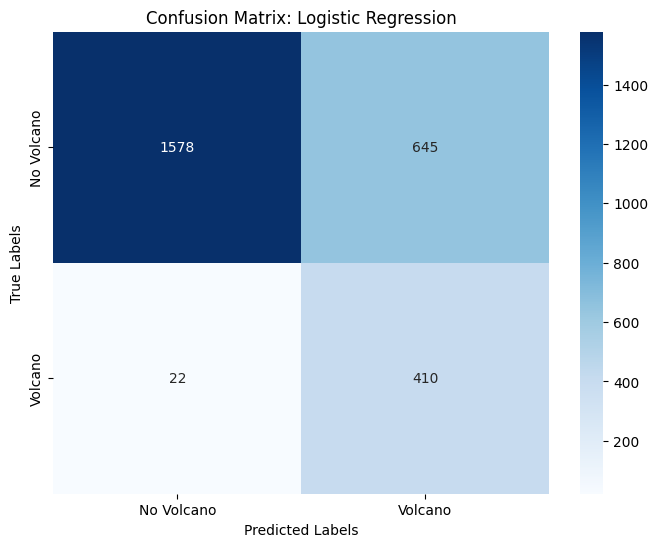

In [25]:
# Confusion matrix visualization

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Volcano", "Volcano"], yticklabels=["No Volcano", "Volcano"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

The confusion matrix shows that the model tends to overestimate the presence of volcanoes, evidenced by a high number of false positives ($=681$). While the model achieves high recall for `Volcano` ($=94\%$), its precision is quite low ($=38\%$), indicating that many `No Volcano` instances are misclassified as `Volcano`. This suggests that the current classification threshold favors identifying volcanoes to maximize recall. To address this, fine-tuning the threshold can help reduce false positives, improving precision and achieving a better balance between precision and recall.

As we did for the learning rate and the regularization hyperparameters, our search for the best threshold to apply will be based on the F1-score, given the unbalanced nature of our dataset.

### Threshold fine-tuning

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score

def predict_and_optimize_threshold(model, X, y_true, metric="f1", thresholds=np.linspace(0.1, 0.9, 50)):
    """
    Predict and optimize the classification threshold for a given metric.

    Parameters:
    -----------
    model : LogisticRegressionSGD
        The trained logistic regression model.
    X : np.ndarray
        Input feature matrix.
    y_true : np.ndarray
        True labels for the input data.
    metric : str, optional (default="f1")
        The metric to optimize. Options: "f1", "precision", "recall".
    thresholds : np.ndarray, optional
        Array of thresholds to evaluate.

    Returns:
    --------
    dict
        A dictionary containing:
        - "best_threshold": The optimal threshold.
        - "best_score": The best score achieved.
        - "predictions": The final predictions using the optimal threshold.
    """
    # Initialize variables to track the best threshold and score
    best_threshold = 0.5
    best_score = 0

    # Generate predicted probabilities
    probabilities = model.sigmoid(X @ model.beta)

    # Loop through thresholds to find the best one
    for threshold in thresholds:
        predictions = (probabilities >= threshold).astype(int)
        if metric == "f1":
            score = f1_score(y_true, predictions)
        elif metric == "precision":
            score = precision_score(y_true, predictions)
        elif metric == "recall":
            score = recall_score(y_true, predictions)
        else:
            raise ValueError("Invalid metric. Choose 'f1', 'precision', or 'recall'.")

        if score > best_score:
            best_score = score
            best_threshold = threshold

    # Generate final predictions using the best threshold
    final_predictions = (probabilities >= best_threshold).astype(int)

    return {
        "best_threshold": best_threshold,
        "best_score": best_score,
        "predictions": final_predictions
    }

# We dinamically add the function to the LogisticRegressionSGD class
setattr(LogisticRegressionSGD, 'predict_and_optimize_threshold', predict_and_optimize_threshold)

In [27]:
# Optimize the threshold for the desired metric (F1-score in this case)
result = final_model.predict_and_optimize_threshold(
    X=X_test_reduced,  # Test feature matrix
    y_true=y_test,     # True test labels
    metric="f1"        # Metric to optimize (F1-score in this case)
)

# Extract results
best_threshold = result["best_threshold"]
best_score = result["best_score"]
final_predictions = result["predictions"]

# Print results
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_score:.4f}")

Optimal Threshold: 0.79
Best F1-Score: 0.7816


In [28]:
from sklearn.metrics import classification_report

# Evaluation of the final model with optmized threshold
print("Classification Report with Optimized Threshold:")
print(classification_report(y_test, final_predictions, target_names=["No Volcano", "Volcano"]))

Classification Report with Optimized Threshold:
              precision    recall  f1-score   support

  No Volcano       0.96      0.96      0.96      2223
     Volcano       0.78      0.79      0.78       432

    accuracy                           0.93      2655
   macro avg       0.87      0.87      0.87      2655
weighted avg       0.93      0.93      0.93      2655



The classification report after optimizing the threshold shows a significant improvement in performance. The accuracy increased to $93\%$, reflecting a more balanced model. The precision for `No Volcano` is high ($0.96$), and recall is also very strong ($0.96$), indicating the model is both accurate and sensitive when predicting `No Volcano`. For `Volcano`, the precision ($0.78$) and recall ($0.79$) have also improved, suggesting a good balance between correctly identifying volcanoes and avoiding false positives.

The macro average F1-score ($0.87$) indicates that the model now performs well across both classes, and the weighted average F1-score ($0.93$) confirms strong overall performance. This optimized threshold achieves a much better balance between precision and recall for both classes, addressing the previous imbalance and improving the model's general effectiveness.

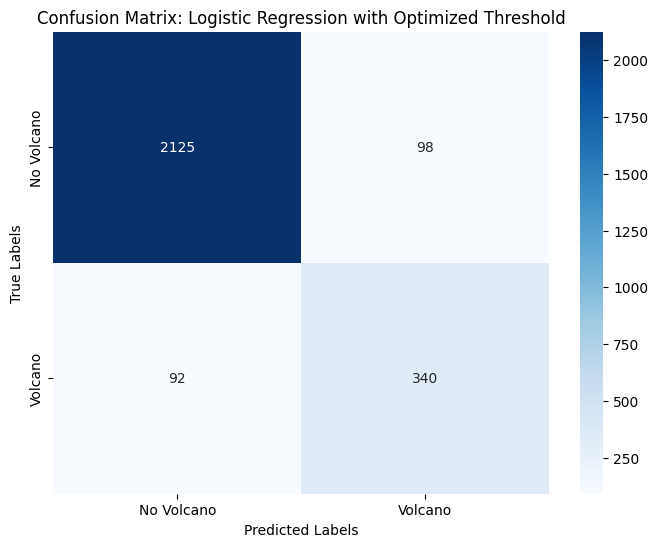

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Volcano", "Volcano"], yticklabels=["No Volcano", "Volcano"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix: Logistic Regression with Optimized Threshold")

# Save the plot as a PDF
plt.savefig("confusion_matrix_log_reg_optimized.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()

The confusion matrix for the final model with the optimized threshold shows strong improvement. For the `No Volcano` class, the model correctly predicts $2125$ instances, with only $92$ false positives. For the `Volcano` class, the model correctly predicts $340$ instances, while $98$ instances are misclassified as `No Volcano`. This improvement in precision and recall, particularly for the `Volcano` class, reflects the effectiveness of adjusting the threshold.

Despite the progress, the key limitation of logistic regression remains its assumption of linearity. This assumption may prevent the model from fully capturing complex patterns in the data. As a result, exploring non-linear classifiers, such as decision trees, random forests, or neural networks, could provide significant performance improvements by better modeling the underlying relationships.